## Import packages

In [1]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler

In [3]:
import mne
from mne import read_evokeds
from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.channels import make_standard_montage, make_eeg_layout
from mne.decoding import CSP, UnsupervisedSpatialFilter
from mne.io.edf import read_raw_edf

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Choose subject and trial

In [5]:
SUBJECT = 2
TRIAL = 1

In [6]:
# TEST_SIZE = 0.2
# TRAIN_TMIN = 0
# TRAIN_TMAX = 0.2

In [7]:
# Make folder for images
import os
import shutil
dir = 'images/images_'+str(SUBJECT)+'_'+str(TRIAL)
if os.path.exists(dir):
    shutil.rmtree(dir)
os.mkdir(dir)

In [8]:
if SUBJECT==1:
    if TRIAL==1:
        bdf_file = 'sessions/0002/Part_1_S_Trial1_emotion.bdf'
        tsv_file = 'sessions/0002/P1-Rec1-Guide-Cut.tsv'
    elif TRIAL==2:
        bdf_file = 'sessions/0004/Part_1_S_Trial2_emotion.bdf'
        tsv_file = 'sessions/0004/P1-Rec1-Guide-Cut.tsv'
    elif TRIAL==3:
        bdf_file = 'sessions/0006/Part_1_S_Trial3_emotion.bdf'
        tsv_file = 'sessions/0006/P1-Rec1-Guide-Cut.tsv'
    else:
        bdf_file = 'sessions/0010/Part_1_S_Trial5_emotion.bdf'
        tsv_file = 'sessions/0010/P1-Rec1-Guide-Cut.tsv'

elif SUBJECT==2:
    if TRIAL==1:
        bdf_file = 'sessions/0132/Part_2_S_Trial1_emotion.bdf'
        tsv_file = 'sessions/0132/P2-Rec1-Guide-Cut.tsv'
    elif TRIAL==2:
        bdf_file = 'sessions/0134/Part_2_S_Trial2_emotion.bdf'
        tsv_file = 'sessions/0134/P2-Rec1-Guide-Cut.tsv'
    elif TRIAL==3:
        bdf_file = 'sessions/0146/Part_2_S_Trial8_emotion.bdf'
        tsv_file = 'sessions/0146/P2-Rec1-Guide-Cut.tsv'
    else:
        bdf_file = 'sessions/0148/Part_2_S_Trial9_emotion.bdf'
        tsv_file = 'sessions/0148/P2-Rec1-Guide-Cut.tsv'
elif SUBJECT==3:
    if TRIAL==1:
        bdf_file = 'sessions/1958/Part_16_S_Trial4_emotion.bdf'
        tsv_file = 'sessions/1958/P16-Rec1-Guide-Cut.tsv'
    elif TRIAL==2:
        bdf_file = 'sessions/1966/Part_16_S_Trial8_emotion.bdf'
        tsv_file = 'sessions/1966/P16-Rec1-Guide-Cut.tsv'
    elif TRIAL==3:
        bdf_file = 'sessions/1972/Part_16_S_Trial11_emotion.bdf'
        tsv_file = 'sessions/1972/P16-Rec1-Guide-Cut.tsv'
    else:
        bdf_file = 'sessions/1964/Part_16_S_Trial7_emotion.bdf'
        tsv_file = 'sessions/1964/P16-Rec1-Guide-Cut.tsv'
elif SUBJECT==4:
    if TRIAL==1:
        bdf_file = 'sessions/1172/Part_10_S_Trial1_emotion.bdf'
        tsv_file = 'sessions/1172/P10-Rec1-Guide-Cut.tsv'
    elif TRIAL==2:
        bdf_file = 'sessions/1174/Part_10_S_Trial2_emotion.bdf'
        tsv_file = 'sessions/1174/P10-Rec1-Guide-Cut.tsv'
    else:
        bdf_file = 'sessions/1186/Part_10_S_Trial8_emotion.bdf'
        tsv_file = 'sessions/1186/P10-Rec1-Guide-Cut.tsv'
else:
    if TRIAL==1:
        bdf_file = 'sessions/1200/Part_10_S_Trial15_emotion.bdf'
        tsv_file = 'sessions/1200/P10-Rec1-Guide-Cut.tsv'    


In [9]:
print(bdf_file)
print(tsv_file)

sessions/0132/Part_2_S_Trial1_emotion.bdf
sessions/0132/P2-Rec1-Guide-Cut.tsv


## Read raw file

In [10]:
raw = mne.io.read_raw_bdf(bdf_file, infer_types=True, preload=True)

Extracting EDF parameters from /data/ai2114/sessions/0132/Part_2_S_Trial1_emotion.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 37631  =      0.000 ...   146.996 secs...


In [11]:
raw

<RawEDF | Part_2_S_Trial1_emotion.bdf, 47 x 37632 (147.0 s), ~13.5 MB, data loaded>

In [12]:
fig = raw.plot(n_channels=47, duration=70, scalings='auto');
fig.savefig('{}/raw.pdf'.format(dir))

Using matplotlib as 2D backend.


## Plot samples

In [13]:
# Extract events from the file and store them in a dataframe along with codes
# The meaning of each code is described in the dataset description
events = mne.find_events(raw, shortest_event=0, output='onset')
events_df = pd.DataFrame(events, columns=['Start', 'onset', 'Code'])

# Print dataframe
events_df

2 events found
Event IDs: [268]


Start  onset  Code
0   7680      0   268
1  29712      0   268

In [14]:
ELECTRODE_INDEX = 2

In [15]:
raw_data = raw._data
print("Number of channels: ", str(len(raw_data)))
print("Number of samples: ", str(len(raw_data[0])))

Number of channels:  47
Number of samples:  37632


In [16]:
fig = plt.figure(figsize=[10, 5])
# Plot EEG signals from 32 electrodes 
for i in np.arange(32):
    plt.plot(raw_data[i,:30000])

plt.axvline(x = events_df['Start'][0], color = 'g', label = 'Start')
plt.axvline(x = events_df['Start'][1], color = 'r', label = 'End')
plt.xlabel('Sample')
plt.ylabel('Voltage (mV)')
plt.title('EEG Samples for all 32 electrodes (Sample 1 to 30000)')
plt.legend()
plt.show()
# fig.savefig('images/sensors.eps')
fig.savefig('{}/raw_samples_32.pdf'.format(dir))

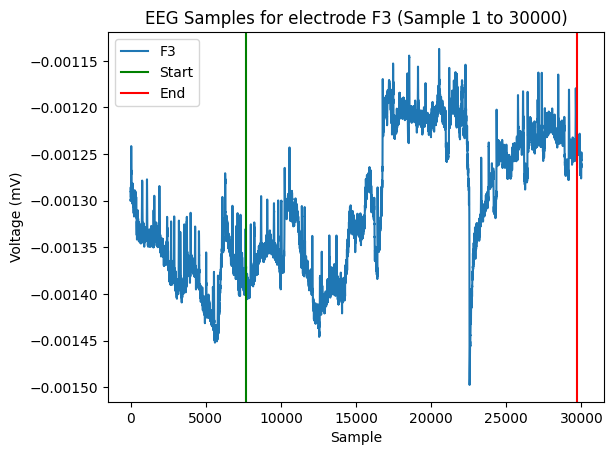

In [17]:
# Fz electrode at channel 19, Pz at 16
plt.close()
# plt.plot(sigbufs[18,:30000], label='Fz')
plt.plot(raw_data[ELECTRODE_INDEX,:30000], label=raw.ch_names[ELECTRODE_INDEX])
plt.axvline(x = events_df['Start'][0], color = 'g', label = 'Start')
plt.axvline(x = events_df['Start'][1], color = 'r', label = 'End')
plt.xlabel('Sample')
plt.ylabel('Voltage (mV)')
plt.title('EEG Samples for electrode '+raw.ch_names[ELECTRODE_INDEX]+' (Sample 1 to 30000)')
plt.legend()
plt.show()

## Drop irrelevant channels

In [18]:
raw = raw.drop_channels(['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Temp'])

In [19]:
raw.ch_names

['Fp1',
 'AF3',
 'F3',
 'F7',
 'FC5',
 'FC1',
 'C3',
 'T7',
 'CP5',
 'CP1',
 'P3',
 'P7',
 'PO3',
 'O1',
 'Oz',
 'Pz',
 'Fp2',
 'AF4',
 'Fz',
 'F4',
 'F8',
 'FC6',
 'FC2',
 'Cz',
 'C4',
 'T8',
 'CP6',
 'CP2',
 'P4',
 'P8',
 'PO4',
 'O2',
 'Status']

## Set EEG reference

In [20]:
raw = raw.set_eeg_reference(ref_channels="average")

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


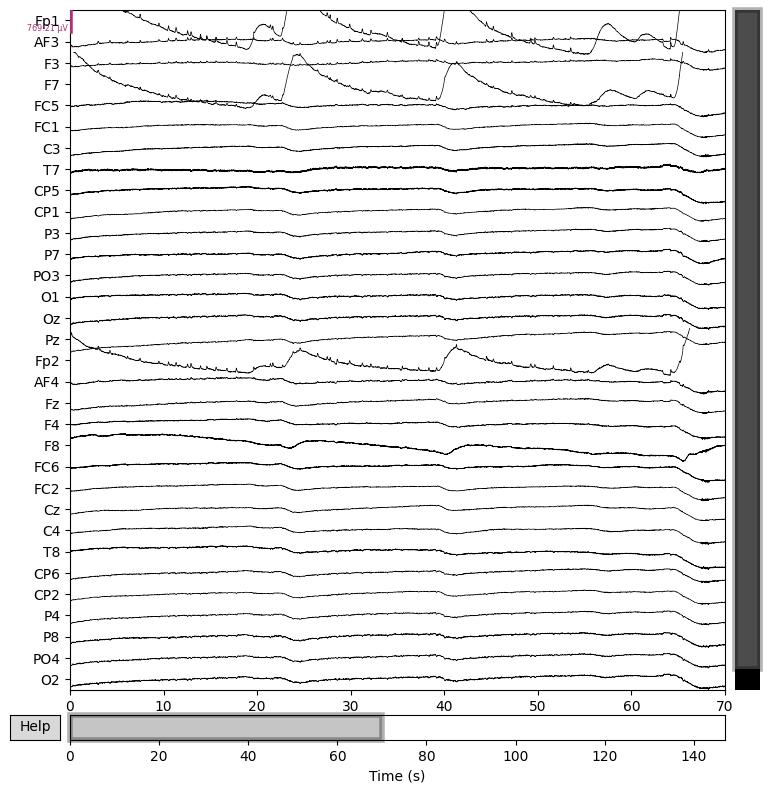

In [21]:
fig = raw.plot(n_channels=32, duration=70, scalings='auto');
fig.savefig('{}/raw_referenced.pdf'.format(dir))

In [22]:
raw_data = raw._data
print("Number of channels: ", str(len(raw_data)))
print("Number of samples: ", str(len(raw_data[0])))

Number of channels:  33
Number of samples:  37632


In [23]:
raw_data.shape

(33, 37632)

In [24]:
# sigbufs = raw_data

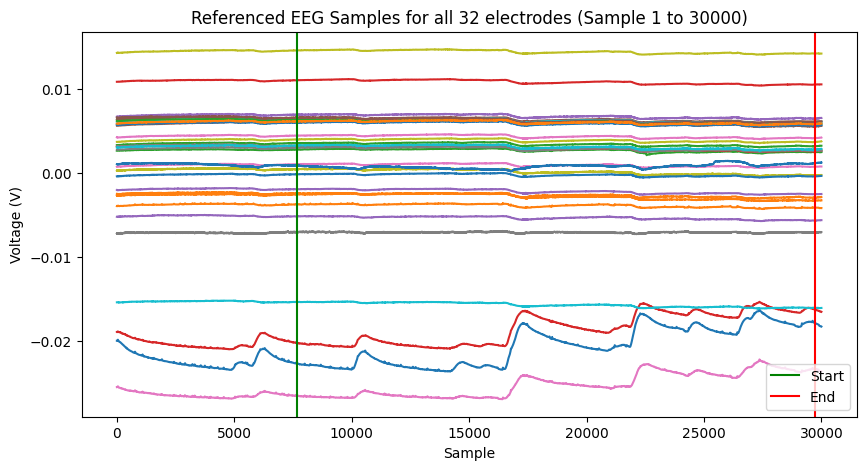

In [25]:
fig = plt.figure(figsize=[10, 5])
# Plot EEG signals from 32 electrodes 
for i in np.arange(32):
    plt.plot(raw_data[i,:30000], alpha=1)

plt.axvline(x = events_df['Start'][0], color = 'g', label = 'Start')
plt.axvline(x = events_df['Start'][1], color = 'r', label = 'End')
plt.xlabel('Sample')
plt.ylabel('Voltage (V)')
plt.title('Referenced EEG Samples for all 32 electrodes (Sample 1 to 30000)')
plt.legend()
plt.show()
# plt.savefig('images/keypress_samples_32.eps', format='eps')
fig.savefig('{}/referenced_samples_32.pdf'.format(dir))


## Set EEG montage

In [26]:
raw.set_montage('standard_1020')

<RawEDF | Part_2_S_Trial1_emotion.bdf, 33 x 37632 (147.0 s), ~9.5 MB, data loaded>

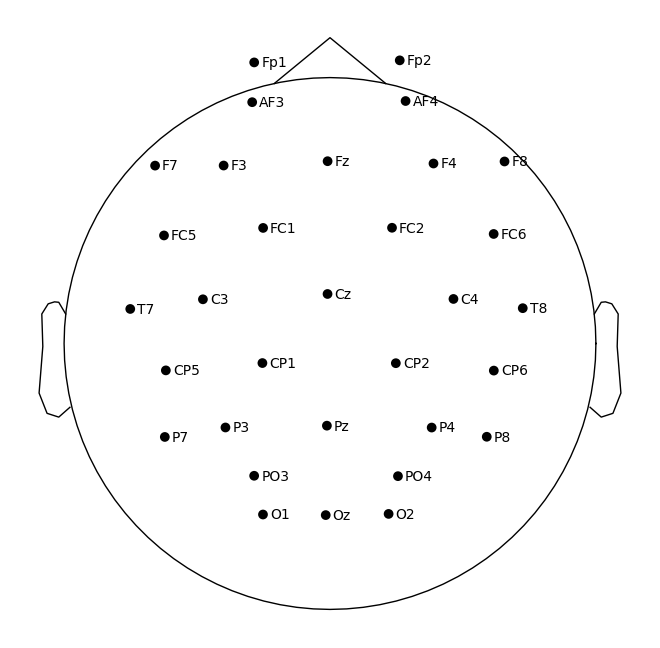

In [27]:
# fig = raw.plot_sensors(show_names=True, sphere=(0.005,0.02,0,0.1))
fig = raw.plot_sensors(show_names=True)
fig.savefig('{}/sensors.pdf'.format(dir))

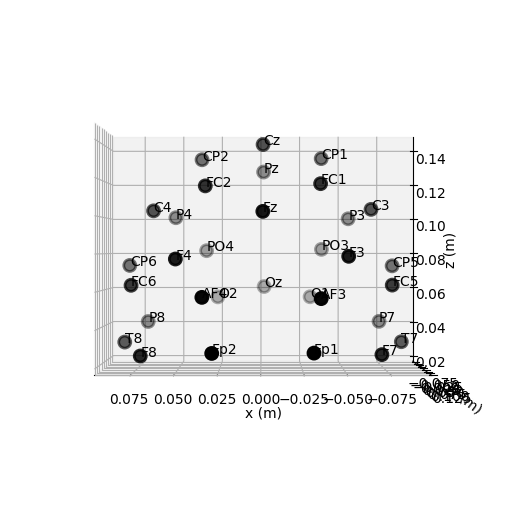

In [28]:
fig = raw.plot_sensors(kind="3d", show_names=True, to_sphere=True)

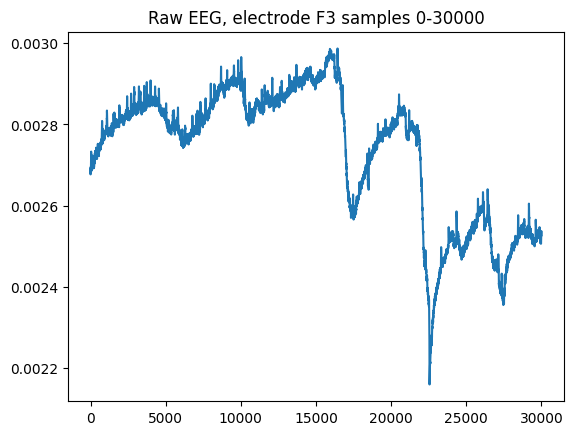

In [29]:
plt.plot(raw_data[ELECTRODE_INDEX,:30000])
plt.title("Raw EEG, electrode "+raw.ch_names[ELECTRODE_INDEX]+" samples 0-30000")
plt.show()

In [30]:
events = mne.find_events(raw, stim_channel="Status")
print(events[:5])  # show the first 5

2 events found
Event IDs: [268]
[[ 7680     0   268]
 [29712     0   268]]


## Choose relevant electrodes

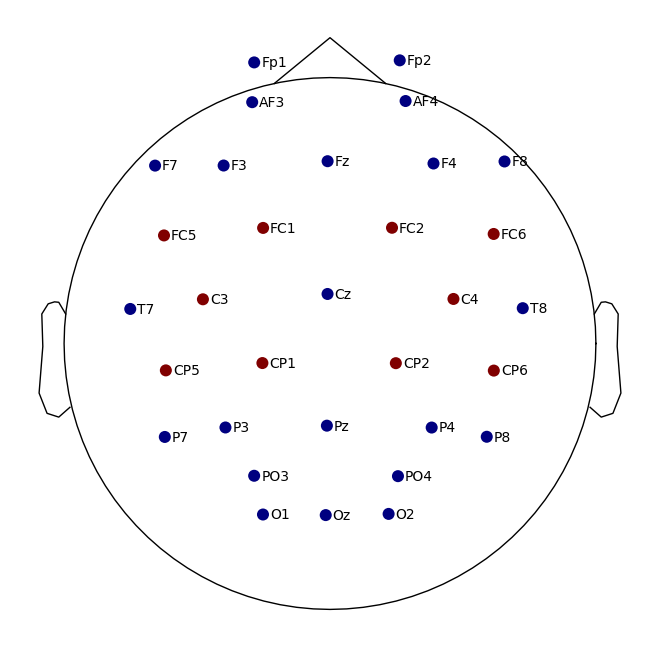

In [31]:
selected_indices = []
not_selected_indices = []
selected = ['FC1', 'FC2', 'FC5', 'FC6', 'CP1', 'CP2', 'CP5', 'CP6', 'C3', 'C4']
for ch_name in raw.ch_names:
    index = raw.ch_names.index(ch_name)
    if ch_name in selected:
        selected_indices.append(index)
    else:
        not_selected_indices.append(index)
# fig = raw.plot_sensors(ch_groups=[selected_indices, not_selected_indices], show_names=True);
fig = mne.viz.plot_sensors(raw.info,
                           ch_groups=[not_selected_indices, selected_indices],
                           show_names=True,
                           linewidth=0,
                           pointsize=75);
fig.savefig('{}/sensors_selected.pdf'.format(dir))

In [32]:
raw = raw.pick(['FC1', 'FC2', 'FC5', 'FC6', 'CP1', 'CP2', 'CP5', 'CP6', 'C3', 'C4','Status'])

In [33]:
raw_data = raw._data
raw_data.shape

(11, 37632)

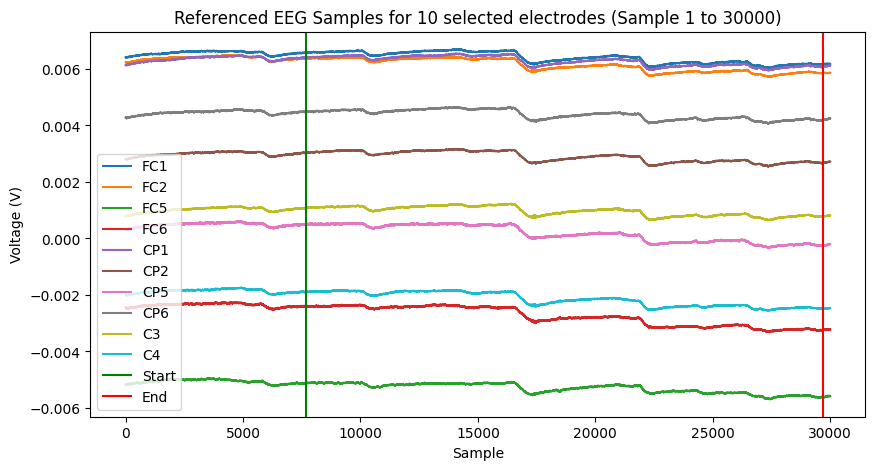

In [34]:
fig = plt.figure(figsize=[10, 5])
# Plot EEG signals from 32 electrodes 
for i in np.arange(10):
    plt.plot(raw_data[i,:30000], label=raw.ch_names[i])

plt.axvline(x = events_df['Start'][0], color = 'g', label = 'Start')
plt.axvline(x = events_df['Start'][1], color = 'r', label = 'End')
plt.xlabel('Sample')
plt.ylabel('Voltage (V)')
plt.title('Referenced EEG Samples for 10 selected electrodes (Sample 1 to 30000)')
plt.legend()
plt.show()
# plt.savefig('images/keypress_samples_32.eps', format='eps')
fig.savefig('{}/referenced_samples_10.pdf'.format(dir))


## Find key presses

In [35]:
data2=pd.read_csv(tsv_file,sep='\t')
data2 = data2[data2['Action']!='LeftMouseClick']
data2 = data2.loc[2:22].reset_index().drop(['index'], axis=1)
data2['AudioSampleNumber'] = data2['AudioSampleNumber'] - data2['AudioSampleCut'][0]
data2['AudioSampleNumber'] = data2['AudioSampleNumber']/256
data2 = data2[data2['Action']=='KeyPress']
data2.reset_index(inplace=True)
data2

index  AudioSampleNumber    Action Name  AudioSampleCut  VideoFrameCut
0      3       19353.095703  KeyPress   D5             NaN            NaN
1      6       21848.537109  KeyPress   D3             NaN            NaN
2      9       23800.197266  KeyPress   D5             NaN            NaN
3     12       25761.369141  KeyPress   D5             NaN            NaN
4     15       27984.876953  KeyPress   D4             NaN            NaN

## Explore key presses

In [36]:
# test = data
# stim_data = np.array(test['label']).reshape(1,-1)
# stim_data = np.concatenate([stim_data, np.zeros(720).reshape(1,-1)], axis=1)
stim_data = np.zeros(len(raw_data[0])).reshape(1,-1)
stim_data.shape

(1, 37632)

In [37]:
for timestamp in data2['AudioSampleNumber']:
    stim_data[0,int(timestamp)] = 1
    # print(timestamp)

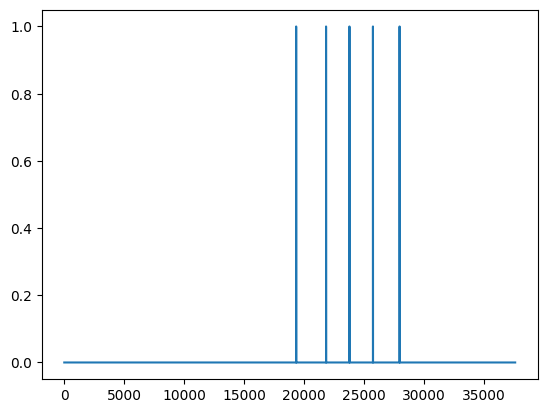

In [38]:
plt.close()
plt.plot(np.arange(stim_data.shape[1]), stim_data[0,:])
plt.show()

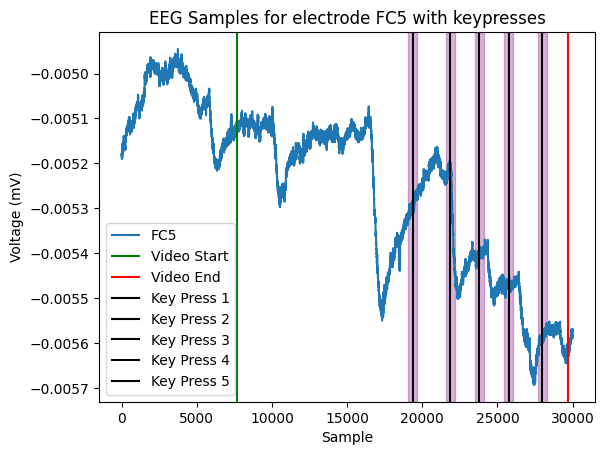

In [39]:
# Fz electrode:
# plt.plot(sigbufs[18,:30000], label='Fz EEG')
plt.plot(raw_data[ELECTRODE_INDEX,:30000], label=raw.ch_names[ELECTRODE_INDEX])
plt.axvline(x = events_df['Start'][0], color = 'g', label = 'Video Start')
plt.axvline(x = events_df['Start'][1], color = 'r', label = 'Video End')

for i, elem in enumerate(data2['AudioSampleNumber']):
    plt.axvline(x = elem, color='black', label = 'Key Press '+str(i+1))
    plt.axvspan(elem-300, elem+300, alpha=.3, color='purple')

plt.xlabel('Sample')
plt.ylabel('Voltage (mV)')
plt.title('EEG Samples for electrode '+raw.ch_names[ELECTRODE_INDEX]+' with keypresses')
plt.legend()
plt.show()

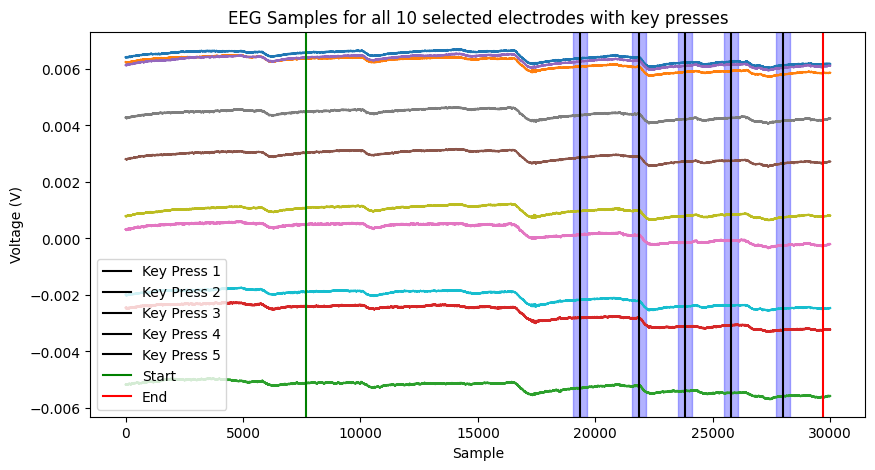

In [40]:
fig = plt.figure(figsize=[10, 5])
# Plot EEG signals from 32 electrodes 
for i in np.arange(10):
    plt.plot(raw_data[i,:30000], alpha=1)

for i, elem in enumerate(data2['AudioSampleNumber']):
    plt.axvline(x = elem, color='black', label = 'Key Press '+str(i+1))
    plt.axvspan(elem-300, elem+300, alpha=.3, color='blue')

plt.axvline(x = events_df['Start'][0], color = 'g', label = 'Start')
plt.axvline(x = events_df['Start'][1], color = 'r', label = 'End')
plt.xlabel('Sample')
plt.ylabel('Voltage (V)')
plt.title('EEG Samples for all 10 selected electrodes with key presses')
plt.legend()
plt.show()
# plt.savefig('images/keypress_samples_32.eps', format='eps')
fig.savefig('{}/keypress_samples_32.pdf'.format(dir))


In [41]:
# stim_data = np.zeros(len(raw.times)).reshape(1,-1)
info = mne.create_info(['KeyPress'], raw.info['sfreq'], ['stim'])
stim_raw = mne.io.RawArray(stim_data, info)
raw.add_channels([stim_raw], force_update_info=True)

Creating RawArray with float64 data, n_channels=1, n_times=37632
    Range : 0 ... 37631 =      0.000 ...   146.996 secs
Ready.


<RawEDF | Part_2_S_Trial1_emotion.bdf, 12 x 37632 (147.0 s), ~3.5 MB, data loaded>

In [42]:
events = mne.find_events(raw, stim_channel=["KeyPress","Status"])
events

2 events found
Event IDs: [268]
5 events found
Event IDs: [1]


/tmp/ipykernel_3362384/1914860326.py:1: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  events = mne.find_events(raw, stim_channel=["KeyPress","Status"])


array([[ 7680,     0,   268],
       [19353,     0,     1],
       [21848,     0,     1],
       [23800,     0,     1],
       [25761,     0,     1],
       [27984,     0,     1],
       [29712,     0,   268]])

In [43]:
event_id = dict(keypress=1, stimulus=268)

/home/ai2114/.local/lib/python3.10/site-packages/mne/viz/misc.py:1391: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if key in unique_events:  # key was a valid event integer


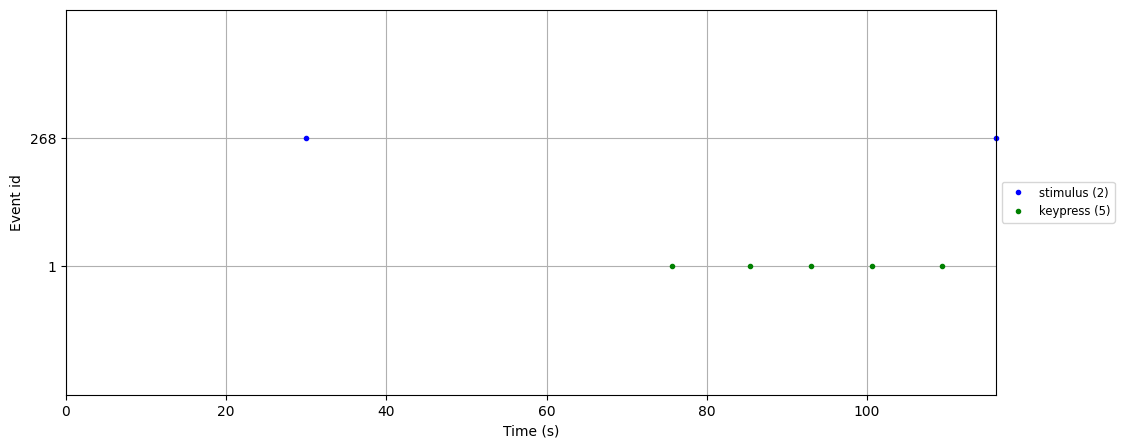

In [44]:
fig, ax = plt.subplots(figsize=[15, 5])

fig = mne.viz.plot_events(events, raw.info['sfreq'],  
                    event_id=event_id,                    
                    axes=ax,
                    color=dict(stimulus="blue", keypress="green"))
plt.show()
fig.savefig('{}/keypress_events.pdf'.format(dir))

In [45]:
events = mne.find_events(raw, stim_channel=["KeyPress"])
event_id = dict(keypress=1)

5 events found
Event IDs: [1]


In [46]:
# picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

In [47]:
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin=-0.5,
    tmax=0.5,
    proj=True,
    # picks=picks,
    baseline=None,
    preload=True
)
# epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1]

Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 257 original time points ...
0 bad epochs dropped


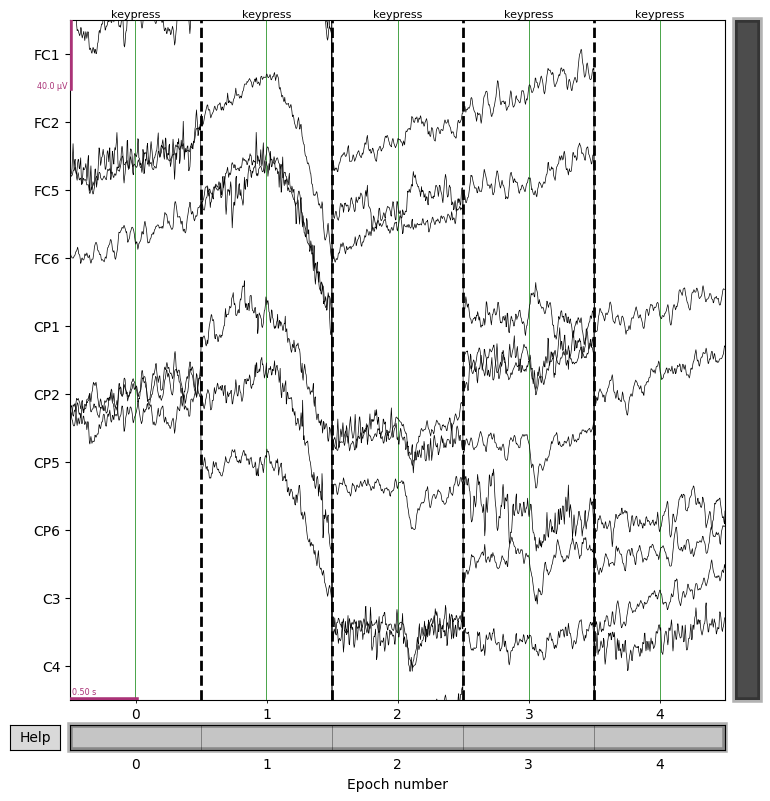

In [48]:
fig = epochs.plot(events=events, event_id=event_id, event_color=dict(keypress="green"));
fig.savefig('{}/keypress_epochs.pdf'.format(dir))

"We plot topo maps at 100 ms steps from the onset of the code up to the end of the epoch. The average kwarg specifies that each plot will reflect the average over a 50 ms time window, centered on each time point for which a plot is drawn. In other words, the plot labeled 0.100 s reflects the average between 50–150 ms." Source: MNE documentation

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


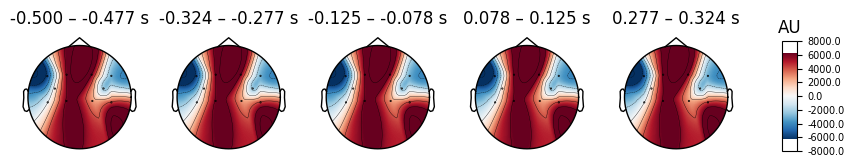

In [49]:
# Specify times to plot at, as [min],[max],[stepsize]
times = np.arange(-0.5, 0.5, 0.2)
fig = epochs.average().plot_topomap(times=times, average=0.05, units='AU');
fig.savefig('{}/keypress_times.pdf'.format(dir))

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


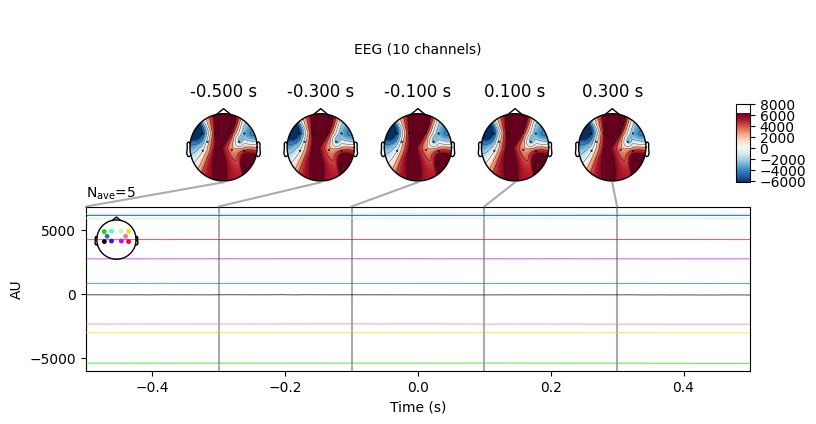

In [50]:
# fig = epochs.average().plot_joint();
fig = epochs.average().plot_joint(times=times, ts_args=dict(scalings=dict(eeg=1e6), units=dict(eeg='AU')),
                                    topomap_args=dict(cbar_fmt='%3.1f'));
fig.savefig('{}/keypress_plot_joint.pdf'.format(dir))

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


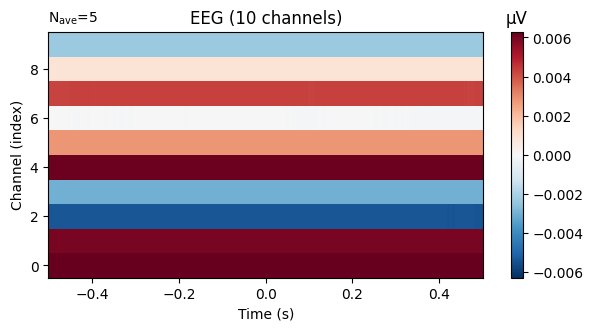

In [51]:
fig = epochs.average().plot_image(scalings=1);
fig.savefig('{}/keypress_plot_image.pdf'.format(dir))

Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated


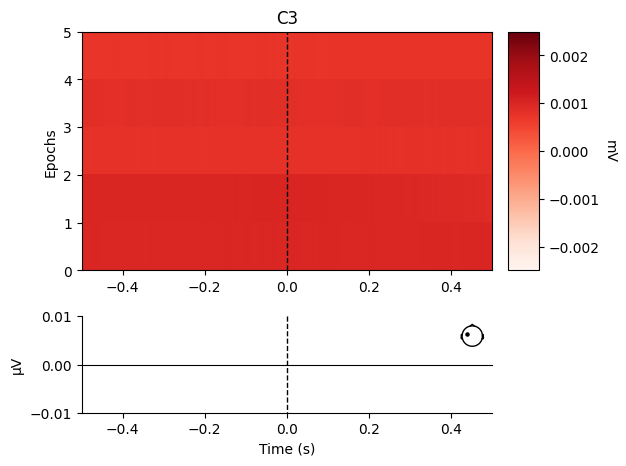

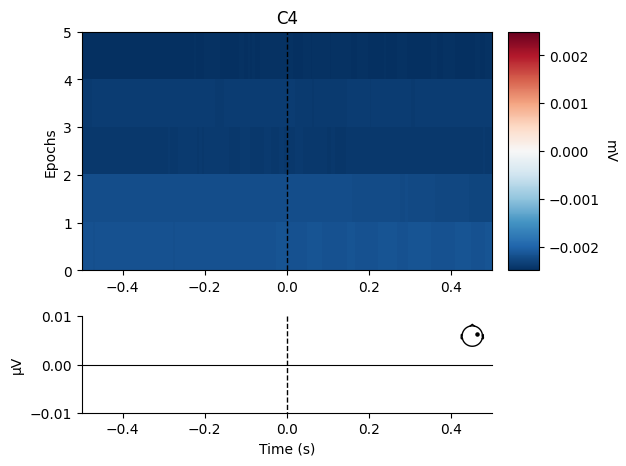

In [52]:
fig = epochs.plot_image(
                        picks=["C3","C4"],
                        units=dict(eeg='mV'),
                        scalings=1,
                        # vmin=lambda data: data.min(),
                        ts_args=dict(ylim=dict(eeg=[-0.01, 0.01])),
                        # evoked=False
                        )

    Using multitaper spectrum estimation with 7 DPSS windows


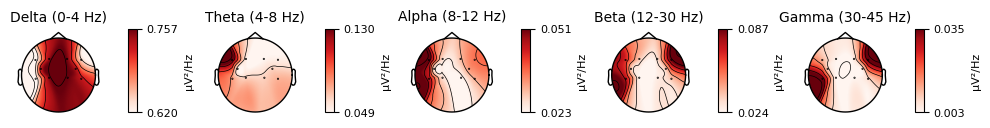

In [53]:
fig = epochs.compute_psd().plot_topomap(normalize=True);
fig.savefig('{}/keypress_psd_topomap.pdf'.format(dir))

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


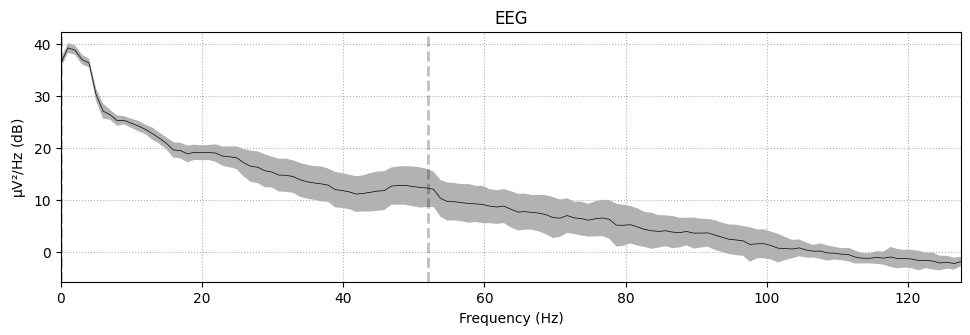

In [54]:
spectrum = epochs.compute_psd()
fig = spectrum.plot(average=True, picks="data", exclude="bads")
plt.show()
fig.savefig('{}/keypress_spectrum.pdf'.format(dir))

## Explore non key presses

In [55]:
stim_data = np.zeros(stim_data.shape[1]).reshape(1,-1)
stim_data.shape

(1, 37632)

In [56]:
def set_nonkeypress_labels():

    if SUBJECT==1:
        if TRIAL==1:
            print("Subject 1 Trial 1")
            stim_data[0,5500] = 1
            stim_data[0,10000] = 1
            stim_data[0,8000] = 1
            stim_data[0,25500] = 1
            stim_data[0,28000] = 1
        elif TRIAL==2:
            print("Subject 1 Trial 2")
            stim_data[0,3000] = 1
            stim_data[0,6500] = 1
            stim_data[0,12500] = 1
            stim_data[0,26500] = 1
            stim_data[0,29500] = 1
        elif TRIAL==3:
            print("Subject 1 Trial 3")
            stim_data[0,1200] = 1
            stim_data[0,5700] = 1
            stim_data[0,10800] = 1
            stim_data[0,24000] = 1
            stim_data[0,28000] = 1
        else:
            print("Subject 1 Trial 4")
            stim_data[0,4000] = 1
            stim_data[0,8000] = 1
            stim_data[0,26000] = 1
            stim_data[0,33000] = 1
            stim_data[0,37500] = 1

    elif SUBJECT==2:
        if TRIAL==1:
            print("Subject 2 Trial 1")
            stim_data[0,2000] = 1
            stim_data[0,7000] = 1
            stim_data[0,9500] = 1
            stim_data[0,11000] = 1
            stim_data[0,31000] = 1
        elif TRIAL==2:
            print("Subject 2 Trial 2")
            stim_data[0,3000] = 1
            stim_data[0,9000] = 1
            stim_data[0,12000] = 1
            stim_data[0,15500] = 1
            stim_data[0,32000] = 1
        elif TRIAL==3:
            print("Subject 2 Trial 3")
            stim_data[0,8500] = 1
            stim_data[0,13000] = 1
            stim_data[0,35000] = 1
            stim_data[0,32000] = 1
            stim_data[0,38000] = 1
        else:
            print("Subject 2 Trial 4")
            stim_data[0,2500] = 1
            stim_data[0,8000] = 1
            stim_data[0,11500] = 1
            stim_data[0,33500] = 1
            stim_data[0,15500] = 1
    elif SUBJECT==3:
        if TRIAL==1:
            print("Subject 3 Trial 1")
            stim_data[0,1200] = 1
            stim_data[0,5800] = 1
            stim_data[0,11700] = 1
            stim_data[0,16800] = 1
            stim_data[0,33500] = 1
        elif TRIAL==2:
            print("Subject 3 Trial 2")
            stim_data[0,1975] = 1
            stim_data[0,9500] = 1
            stim_data[0,33000] = 1
            stim_data[0,36000] = 1
            stim_data[0,39000] = 1
        elif TRIAL==3:
            print("Subject 3 Trial 3")
            stim_data[0,2300] = 1
            stim_data[0,5600] = 1
            stim_data[0,9850] = 1
            stim_data[0,17500] = 1
            stim_data[0,34000] = 1
        else:
            print("Subject 3 Trial 4")
            stim_data[0,4000] = 1
            stim_data[0,8000] = 1
            stim_data[0,12000] = 1
            stim_data[0,16000] = 1
            stim_data[0,20000] = 1
    elif SUBJECT==4:
        if TRIAL==1:
            print("Subject 4 Trial 1")
            stim_data[0,1700] = 1
            stim_data[0,6000] = 1
            stim_data[0,9500] = 1
            stim_data[0,22000] = 1
            stim_data[0,26000] = 1
        elif TRIAL==2:
            print("Subject 4 Trial 2")
            stim_data[0,2500] = 1
            stim_data[0,5000] = 1
            stim_data[0,7500] = 1
            stim_data[0,19000] = 1
            stim_data[0,23000] = 1
        else:
            print("Subject 4 Trial 3")
            stim_data[0,2000] = 1
            stim_data[0,3500] = 1
            stim_data[0,9000] = 1
            stim_data[0,23000] = 1
            stim_data[0,26500] = 1
    else:
        if TRIAL==1:
            print("Subject 5 Trial 1")
            stim_data[0,3500] = 1
            stim_data[0,7500] = 1
            stim_data[0,23000] = 1
            stim_data[0,26000] = 1
            stim_data[0,32000] = 1

In [57]:
set_nonkeypress_labels()

Subject 2 Trial 1


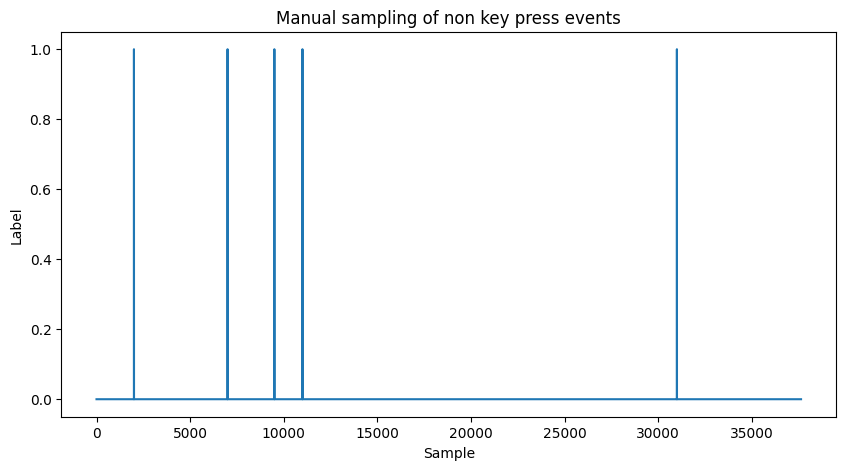

In [58]:
plt.close()
fig = plt.figure(figsize=[10, 5])
plt.plot(np.arange(stim_data.shape[1]), stim_data[0,:])
plt.xlabel('Sample')
plt.ylabel('Label')
plt.title('Manual sampling of non key press events')
plt.show()
fig.savefig('{}/nonkeypress_labels.pdf'.format(dir))

In [59]:
# stim_data = np.zeros(len(raw.times)).reshape(1,-1)
info = mne.create_info(['NonKeyPress'], raw.info['sfreq'], ['stim'])
stim_raw = mne.io.RawArray(stim_data, info)
raw.add_channels([stim_raw], force_update_info=True)

Creating RawArray with float64 data, n_channels=1, n_times=37632
    Range : 0 ... 37631 =      0.000 ...   146.996 secs
Ready.


<RawEDF | Part_2_S_Trial1_emotion.bdf, 13 x 37632 (147.0 s), ~3.8 MB, data loaded>

In [60]:
events = mne.find_events(raw, stim_channel=["NonKeyPress","Status"])
events

2 events found
Event IDs: [268]
5 events found
Event IDs: [1]


/tmp/ipykernel_3362384/1904400979.py:1: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  events = mne.find_events(raw, stim_channel=["NonKeyPress","Status"])


array([[ 2000,     0,     1],
       [ 7000,     0,     1],
       [ 7680,     0,   268],
       [ 9500,     0,     1],
       [11000,     0,     1],
       [29712,     0,   268],
       [31000,     0,     1]])

In [61]:
event_id = dict(nonkeypress=1, stimulus=268)

/home/ai2114/.local/lib/python3.10/site-packages/mne/viz/misc.py:1391: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if key in unique_events:  # key was a valid event integer


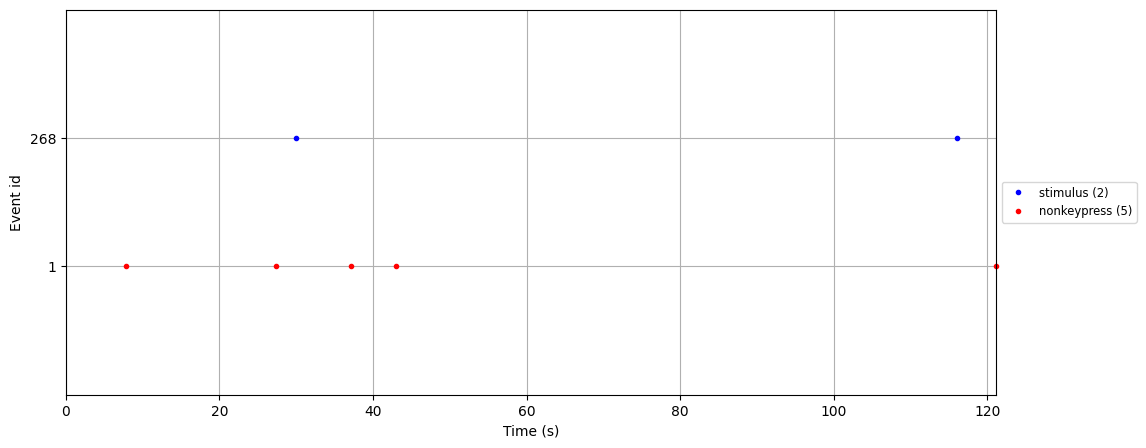

In [62]:
fig, ax = plt.subplots(figsize=[15, 5])

fig = mne.viz.plot_events(events, raw.info['sfreq'],  
                    event_id=event_id,                    
                    axes=ax,
                    color=dict(stimulus="blue", nonkeypress="red"))
plt.show()
fig.savefig('{}/nonkeypress_events.pdf'.format(dir))

In [63]:
events = mne.find_events(raw, stim_channel=["NonKeyPress"])
event_id = dict(nonkeypress=1)

5 events found
Event IDs: [1]


In [64]:
# picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

In [65]:
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin=-0.5,
    tmax=0.5,
    proj=True,
    # picks=picks,
    baseline=None,
    preload=True
)
# epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1]

Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 257 original time points ...
0 bad epochs dropped


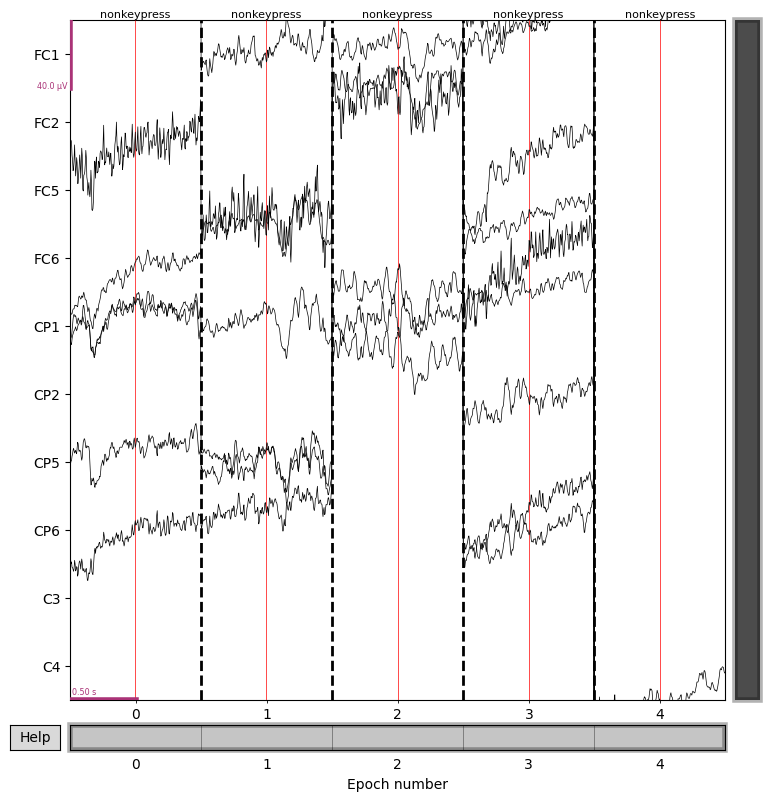

In [66]:
fig = epochs.plot(events=events, event_id=event_id, event_color=dict(nonkeypress="red"));
fig.savefig('{}/nonkeypress_epochs.pdf'.format(dir))

In [67]:
# Specify times to plot at, as [min],[max],[stepsize]
times = np.arange(-0.5, 0.5, 0.2)
fig = epochs.average().plot_topomap(times=times, average=0.05, units='AU');
fig.savefig('{}/nonkeypress_times.pdf'.format(dir))

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


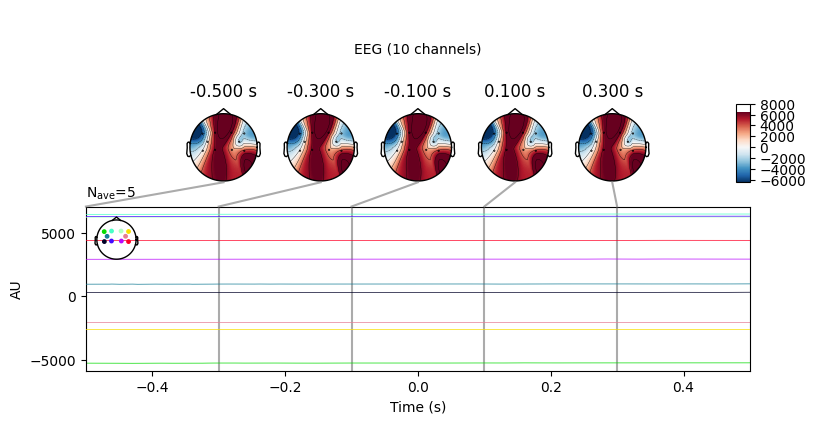

In [68]:
# fig = epochs.average().plot_joint();
fig = epochs.average().plot_joint(times=times, ts_args=dict(scalings=dict(eeg=1e6), units=dict(eeg='AU')),
                                    topomap_args=dict(cbar_fmt='%3.1f'));
fig.savefig('{}/nonkeypress_plot_joint.pdf'.format(dir))

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


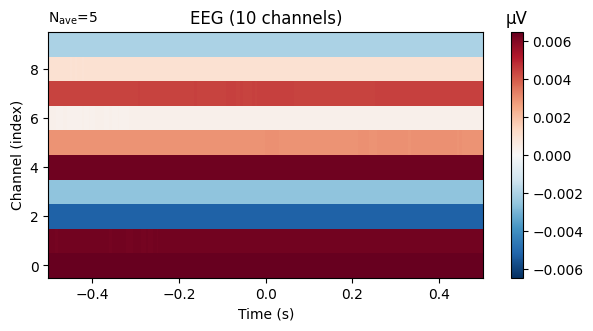

In [69]:
fig = epochs.average().plot_image(scalings=1);
fig.savefig('{}/nonkeypress_plot_image.pdf'.format(dir))

Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated


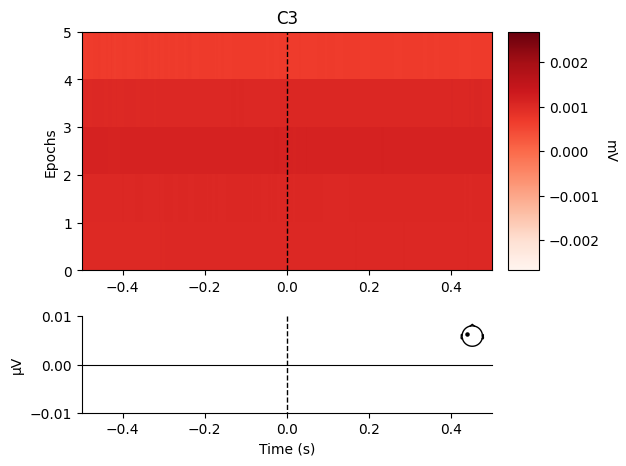

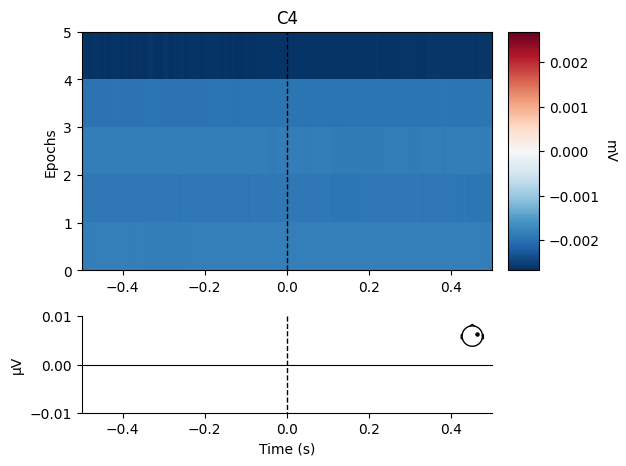

In [70]:
fig = epochs.plot_image(
                        picks=["C3", "C4"],
                        units=dict(eeg='mV'),
                        scalings=1,
                        # vmin=lambda data: data.min(),
                        ts_args=dict(ylim=dict(eeg=[-0.01, 0.01])),
                        # evoked=False
                        )

    Using multitaper spectrum estimation with 7 DPSS windows


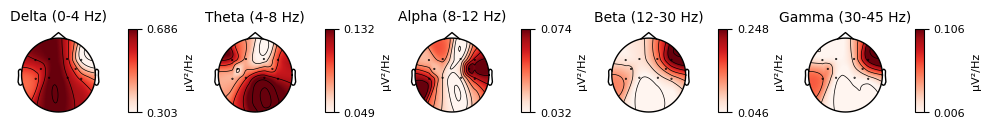

In [71]:
fig = epochs.compute_psd().plot_topomap(normalize=True);
fig.savefig('{}/nonkeypress_psd_topomap.pdf'.format(dir))

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


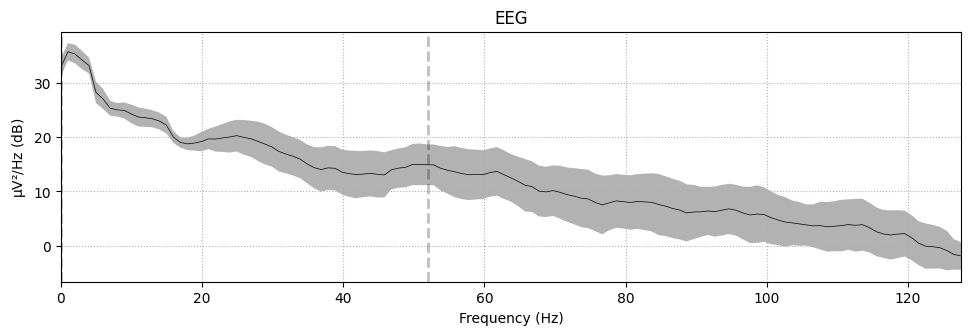

In [72]:
spectrum = epochs.compute_psd()
fig = spectrum.plot(average=True, picks="data", exclude="bads")
plt.show()
fig.savefig('{}/nonkeypress_spectrum.pdf'.format(dir))

## Classifier

In [73]:
for timestamp in data2['AudioSampleNumber']:
    stim_data[0,int(timestamp)] = 2
    # print(timestamp)

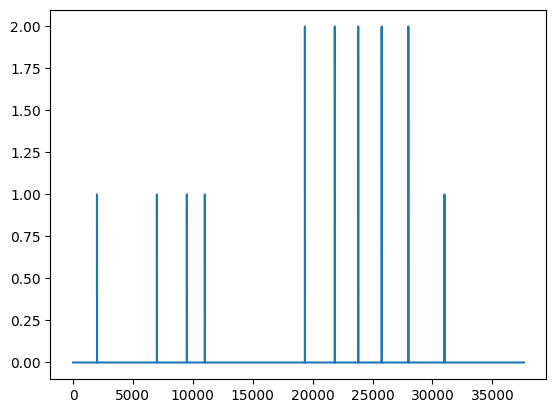

In [74]:
plt.close()
plt.plot(np.arange(stim_data.shape[1]), stim_data[0,:])
plt.show()

In [75]:
set_nonkeypress_labels()

Subject 2 Trial 1


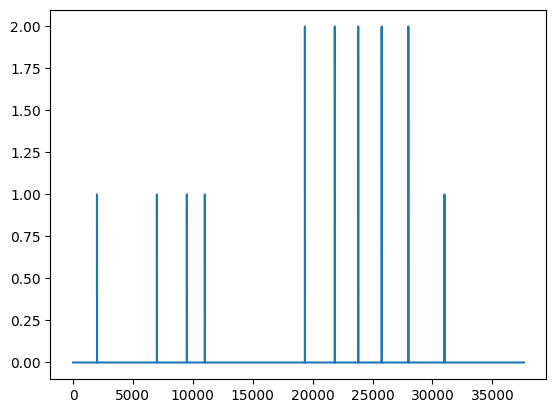

In [76]:
plt.close()
plt.plot(np.arange(stim_data.shape[1]), stim_data[0,:])
plt.show()

In [77]:
# stim_data = np.zeros(len(raw.times)).reshape(1,-1)
info = mne.create_info(['AllKeyPress'], raw.info['sfreq'], ['stim'])
stim_raw = mne.io.RawArray(stim_data, info)
raw.add_channels([stim_raw], force_update_info=True)

Creating RawArray with float64 data, n_channels=1, n_times=37632
    Range : 0 ... 37631 =      0.000 ...   146.996 secs
Ready.


<RawEDF | Part_2_S_Trial1_emotion.bdf, 14 x 37632 (147.0 s), ~4.1 MB, data loaded>

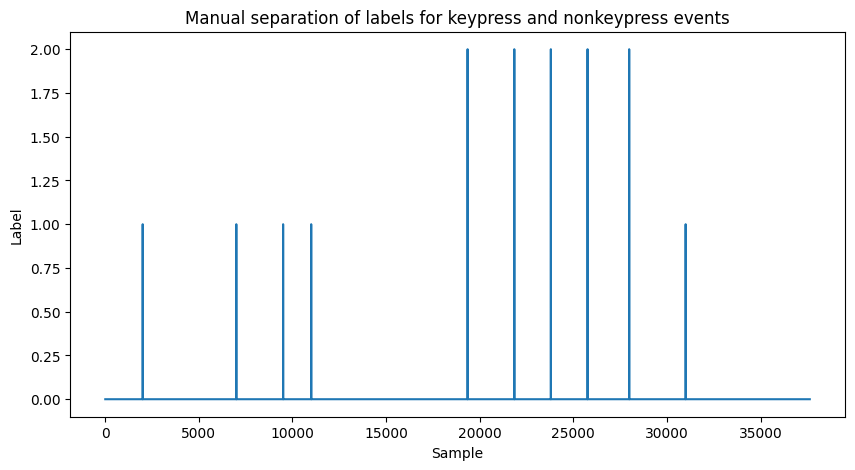

In [78]:
plt.close()
fig = plt.figure(figsize=[10, 5])
raw_data = raw._data
# plt.plot(raw_data[35,:])
plt.plot(raw_data[13,:])
plt.xlabel('Sample')
plt.ylabel('Label')
plt.title('Manual separation of labels for keypress and nonkeypress events')
plt.show()
fig.savefig('{}/allkeypress_labels.pdf'.format(dir))

In [79]:
raw.first_samp

0

In [80]:
events = mne.find_events(raw, stim_channel=["AllKeyPress","Status"])
events

2 events found
Event IDs: [268]
10 events found
Event IDs: [1 2]


/tmp/ipykernel_3362384/675141380.py:1: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  events = mne.find_events(raw, stim_channel=["AllKeyPress","Status"])


array([[ 2000,     0,     1],
       [ 7000,     0,     1],
       [ 7680,     0,   268],
       [ 9500,     0,     1],
       [11000,     0,     1],
       [19353,     0,     2],
       [21848,     0,     2],
       [23800,     0,     2],
       [25761,     0,     2],
       [27984,     0,     2],
       [29712,     0,   268],
       [31000,     0,     1]])

In [81]:
event_id = dict(keypress=2, nonkeypress=1, stimulus=268)

/home/ai2114/.local/lib/python3.10/site-packages/mne/viz/misc.py:1391: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if key in unique_events:  # key was a valid event integer


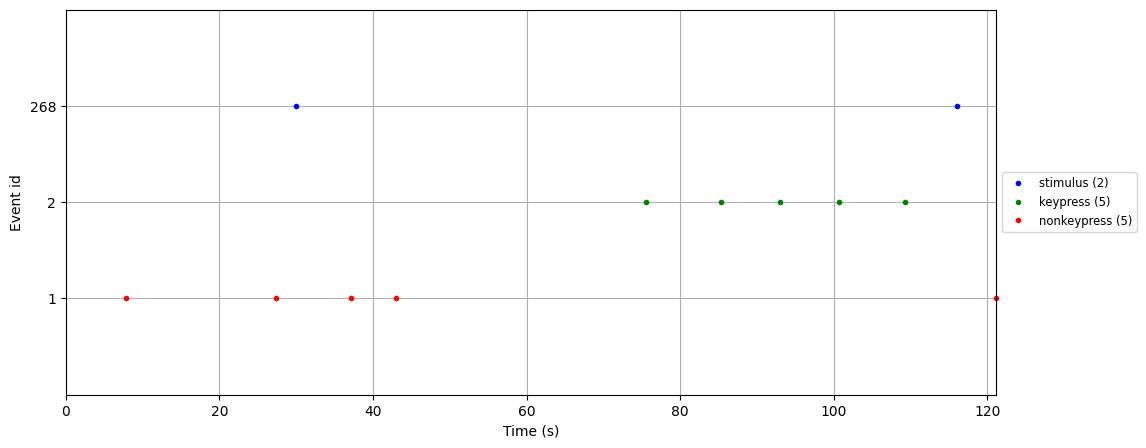

In [82]:
fig, ax = plt.subplots(figsize=[15, 5])

fig = mne.viz.plot_events(events, raw.info['sfreq'],  
                    event_id=event_id,                    
                    axes=ax,
                    color=dict(stimulus="blue", keypress="green", nonkeypress="red"))
plt.show()
fig.savefig('{}/allkeypress_events.pdf'.format(dir))

In [83]:
# picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

In [84]:
events = mne.find_events(raw, stim_channel=["AllKeyPress"])
event_id = dict(key=2, non_key=1)

10 events found
Event IDs: [1 2]


In [85]:
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin=-0.5,
    tmax=0.5,
    proj=True,
    # picks=picks,
    baseline=None,
    preload=True
)


Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 257 original time points ...
0 bad epochs dropped


In [86]:
epochs_train = epochs.copy().crop(tmin=0, tmax=0.2)
labels = epochs.events[:, -1]

In [87]:
epochs

<Epochs |  10 events (all good), -0.5 – 0.5 s, baseline off, ~314 kB, data loaded,
 'key': 5
 'non_key': 5>

In [88]:
labels

array([1, 1, 1, 1, 2, 2, 2, 2, 2, 1])

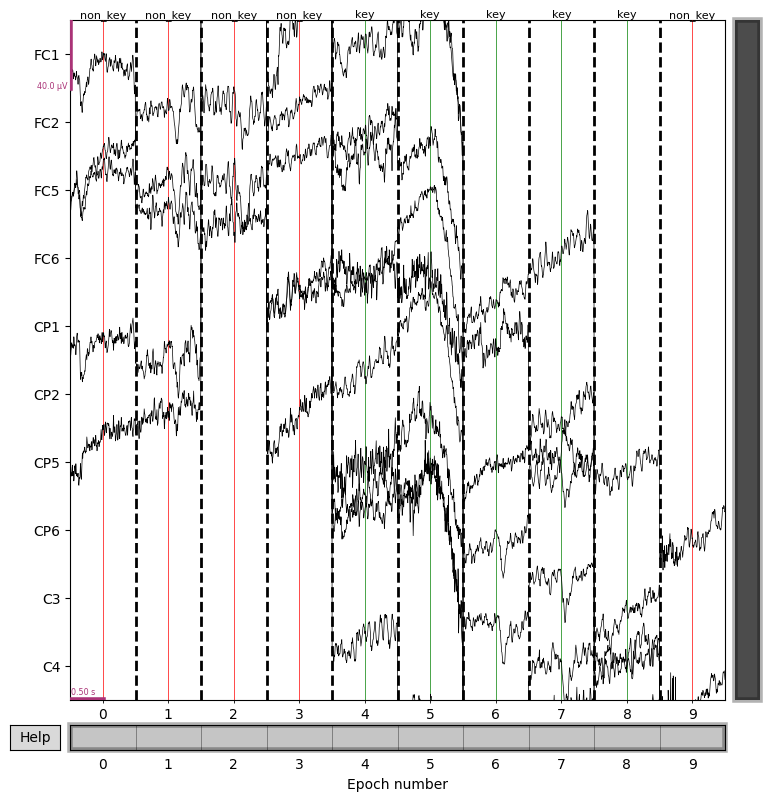

In [89]:
fig = epochs.plot(events=events, event_id=event_id, event_color=dict(key="green", non_key="red"));
fig.savefig('{}/allkeypress_epochs.pdf'.format(dir))

Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


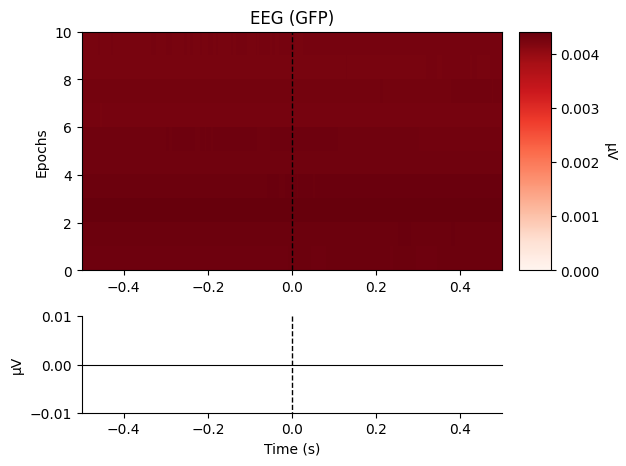

In [90]:
fig = epochs.plot_image(
                        # picks=["F7", "Fp1", "Pz"],
                        scalings=1,
                        # vmin=lambda data: data.min(),
                        ts_args=dict(ylim=dict(eeg=[-0.01, 0.01])),
                        # evoked=False
                        )

In [91]:
spectrum = epochs.compute_psd()
# spectrum.plot(average=False, picks="data", exclude="bads")

    Using multitaper spectrum estimation with 7 DPSS windows


In [92]:
spectrum.get_data().shape

(10, 10, 129)

## Scale epochs data

In [93]:
epochs_data = epochs.get_data()
# epochs_data_train = epochs_train.get_data()
print(epochs_data.shape)
# print(epochs_data_train.shape)

(10, 14, 257)


In [94]:
epochs_data_copy = epochs_data.copy()
epochs_data_copy = np.moveaxis(epochs_data_copy, 1,2)
epochs_data_copy = epochs_data_copy[:,:,:10]
epochs_data_copy.shape

(10, 257, 10)

In [95]:
# scaler = StandardScaler()
# for i in range(10):
#     epochs_data_copy[i,:,:] = scaler.fit_transform(epochs_data_copy[i,:,:])

## PCA features

In [96]:
epoch_plot = 0

In [97]:
pca = PCA(5)
pca_data = pca.fit_transform(epochs_data_copy[epoch_plot,:,:])
pca_data.shape

(257, 5)

In [98]:
plt.close()
fig = plt.figure(figsize=[10, 5])
for i in range(10):
    plt.plot(epochs_data_copy[epoch_plot,:,i], label=raw.ch_names[i])
plt.xlabel('Sample')
plt.ylabel('Voltage (V)')
plt.title('Referenced EEG Samples for 1 epoch from 10 Selected Electrodes')
plt.legend()
plt.show()
fig.savefig('{}/1_epoch_samples.pdf'.format(dir))

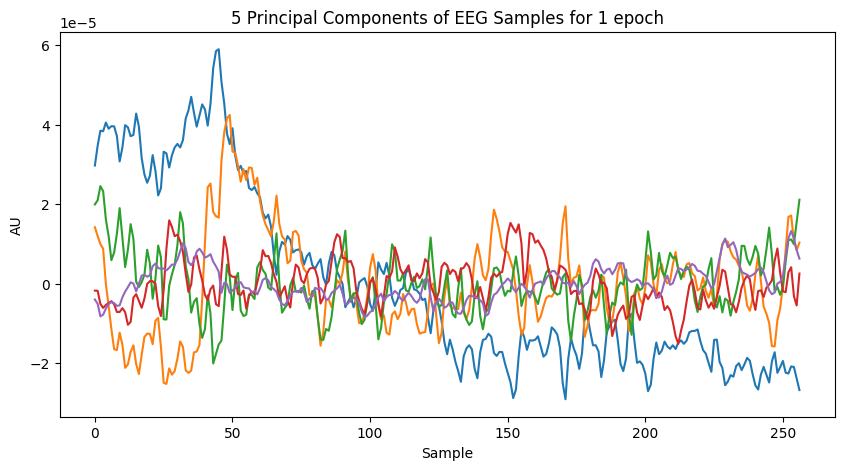

In [99]:
plt.close()
fig = plt.figure(figsize=[10, 5])
for i in range(5):
    plt.plot(pca_data[:,i])
plt.xlabel('Sample')
plt.ylabel('AU')
plt.title('5 Principal Components of EEG Samples for 1 epoch')
plt.show()
fig.savefig('{}/1_epoch_pca.pdf'.format(dir))

In [100]:
epochs_data_copy.shape

(10, 257, 10)

In [102]:
pca=PCA(5)
usf = UnsupervisedSpatialFilter(pca, average=False)
usf_pca_data = usf.fit_transform(epochs_data_copy[:,:,:])
ev = mne.EvokedArray(
    np.mean(usf_pca_data, axis=0),
    mne.create_info(5, epochs.info["sfreq"], ch_types="eeg"),
    tmin=0,
)
fig = ev.plot(show=True, window_title="PCA", time_unit="s", units=dict(eeg='AU'), titles=dict(eeg=''))
# plt.show()
fig.savefig('{}/1_epoch_usf_pca.pdf'.format(dir), bbox_inches='tight')

In [103]:
print(epochs_data_copy[:,:,:].shape)
print(usf_pca_data.shape)
# print(ev.get_data().shape)

(10, 257, 10)
(10, 5, 10)


In [104]:
csp_usf_pca = CSP(n_components=5, reg=None, log=True, norm_trace=False)
csp_usf_pca_data = csp_usf_pca.fit_transform(usf_pca_data, labels)
csp_usf_pca_data.shape

Computing rank from data with rank=None
    Using tolerance 0.0005 (2.2e-16 eps * 5 dim * 4.5e+11  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0005 (2.2e-16 eps * 5 dim * 4.5e+11  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.


(10, 5)

## ICA features

In [105]:
ica = FastICA(5, whiten="unit-variance")
ica_data = ica.fit_transform(epochs_data_copy[epoch_plot,:,:10])
ica_data.shape

(257, 5)

In [106]:
plt.close()
fig = plt.figure(figsize=[10, 5])
for i in range(5):
    plt.plot(ica_data[:,i])
plt.xlabel('Sample')
plt.ylabel('AU')
plt.title('5 Independent Components of EEG Samples for 1 epoch')
plt.show()
fig.savefig('{}/1_epoch_ica.pdf'.format(dir))

In [107]:
ica = FastICA(5, whiten="unit-variance")
usf = UnsupervisedSpatialFilter(ica, average=False)
usf_ica_data = usf.fit_transform(epochs_data_copy[:,:,:10])
ev = mne.EvokedArray(
    np.mean(usf_ica_data, axis=0),
    mne.create_info(5, epochs.info["sfreq"], ch_types="eeg"),
    tmin=0,
)
fig = ev.plot(show=True, window_title="ICA", time_unit="s", units=dict(eeg='AU'), titles=dict(eeg=''))
# plt.show()
fig.savefig('{}/1_epoch_usf_ica.pdf'.format(dir), bbox_inches='tight')

In [108]:
print(usf_ica_data.shape)
print(ev.get_data().shape)

(10, 5, 10)
(5, 10)


In [109]:
csp_ica = CSP(n_components=5, reg=None, log=True, norm_trace=False)
csp_ica_data = csp_ica.fit_transform(usf_ica_data, labels)
csp_ica_data.shape

Computing rank from data with rank=None
    Using tolerance 0.01 (2.2e-16 eps * 5 dim * 9e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.011 (2.2e-16 eps * 5 dim * 9.6e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.


(10, 5)

In [110]:
# ICA parameters
random_state = 42   # ensures ICA is reproducable each time it's run
ica_n_components = .95     # Specify n_components as a decimal to set % explained variance

# Fit ICA
ica = mne.preprocessing.ICA(n_components=5,
                            random_state=random_state,
                            )
ica.fit(epochs,
        reject=None)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 5 components
Fitting ICA took 0.0s.


/tmp/ipykernel_3362384/17408905.py:9: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(epochs,


<ICA | epochs decomposition, method: fastica (fit in 18 iterations on 2570 samples), 5 ICA components (10 PCA components available), channel types: eeg, no sources marked for exclusion>

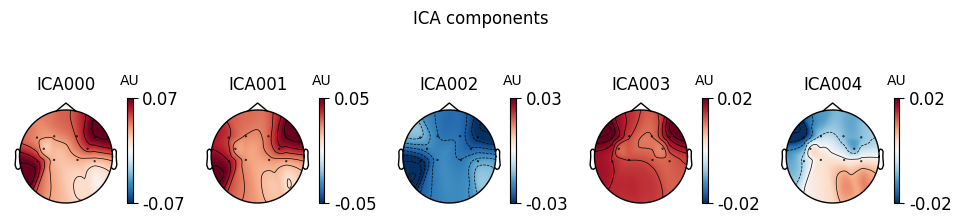

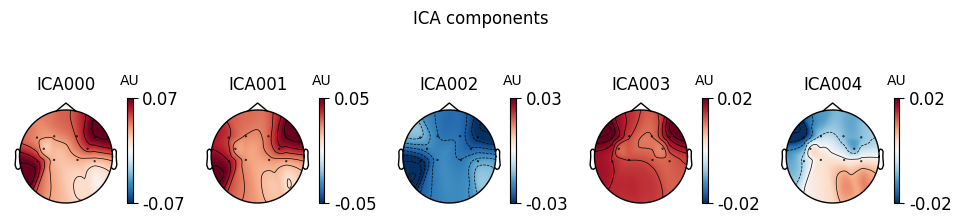

In [111]:
fig = ica.plot_components(colorbar=True);
fig[0].savefig('{}/ica_topography.pdf'.format(dir))
fig[0]

In [112]:
# ICA parameters
random_state = 42   # ensures ICA is reproducable each time it's run
ica_n_components = .95     # Specify n_components as a decimal to set % explained variance

# Fit ICA
ica = mne.preprocessing.ICA(n_components=5,
                            random_state=random_state,
                            )
ica.fit(epochs['key'],
        reject=None)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 5 components
Fitting ICA took 0.0s.


/tmp/ipykernel_3362384/2037150086.py:9: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(epochs['key'],


<ICA | epochs decomposition, method: fastica (fit in 22 iterations on 1285 samples), 5 ICA components (10 PCA components available), channel types: eeg, no sources marked for exclusion>

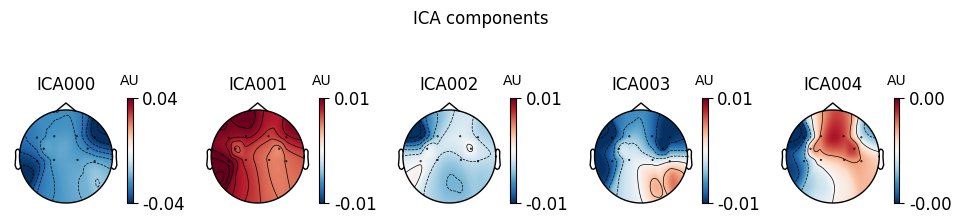

In [113]:
fig = ica.plot_components(colorbar=True);
# fig[0].savefig('{}/ica_topography.pdf'.format(dir))
# fig[0]

In [114]:
# ICA parameters
random_state = 42   # ensures ICA is reproducable each time it's run
ica_n_components = .95     # Specify n_components as a decimal to set % explained variance

# Fit ICA
ica = mne.preprocessing.ICA(n_components=5,
                            random_state=random_state,
                            )
ica.fit(epochs['non_key'],
        reject=None)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 5 components
Fitting ICA took 0.0s.


/tmp/ipykernel_3362384/3424453164.py:9: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(epochs['non_key'],


<ICA | epochs decomposition, method: fastica (fit in 10 iterations on 1285 samples), 5 ICA components (10 PCA components available), channel types: eeg, no sources marked for exclusion>

In [115]:
fig = ica.plot_components(colorbar=True);
# fig[0].savefig('{}/ica_topography.pdf'.format(dir))
# fig[0]

## Plot CSP features

Computing rank from data with rank=None
    Using tolerance 0.0011 (2.2e-16 eps * 10 dim * 4.9e+11  max singular value)
    Estimated rank (mag): 10
    MAG: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0011 (2.2e-16 eps * 10 dim * 4.9e+11  max singular value)
    Estimated rank (mag): 10
    MAG: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating covariance using EMPIRICAL
Done.


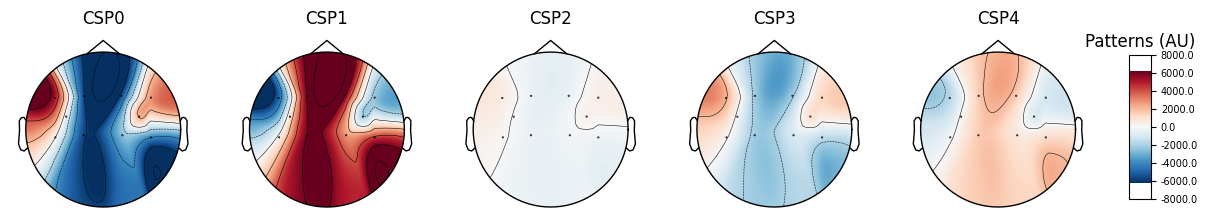

In [116]:
epochs_csp = epochs.copy()
epochs_csp = epochs_csp.pick(selected)
epochs_csp_data = epochs_csp.get_data()

csp_test = CSP(n_components=5, reg=None, log=True, norm_trace=False)

csp_test.fit_transform(epochs_csp_data, labels)

fig = csp_test.plot_patterns(epochs_csp.info, ch_type="eeg", units="Patterns (AU)", size=1.5);
fig.savefig('{}/csp_features.pdf'.format(dir))

## Create classification pipeline

In [117]:
lda = LDA()
svc = SVC()
csp = CSP(n_components=5, reg=None, log=True, norm_trace=False)

In [118]:
# Use scikit-learn Pipeline with cross_val_score function
# clf = Pipeline([("CSP", csp), ("LDA", lda)])

clf_lda = make_pipeline(
    UnsupervisedSpatialFilter(PCA(5), average=False),
    csp,
    StandardScaler(),
    lda
)

clf_svc = make_pipeline(
    UnsupervisedSpatialFilter(PCA(5), average=False),
    csp,
    StandardScaler(),
    svc
)

## CV scores

In [119]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
# epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
# cv_split = cv.split(epochs_data_train)
cv_split = cv.split(epochs_data)

In [120]:
scores_lda = cross_val_score(clf_lda, epochs_data, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(
    "Classification accuracy: %f / Chance level: %f" % (np.mean(scores_lda), class_balance)
)

Computing rank from data with rank=None
    Using tolerance 0.0031 (2.2e-16 eps * 5 dim * 2.8e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.005 (2.2e-16 eps * 5 dim * 4.5e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0027 (2.2e-16 eps * 5 dim * 2.4e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0055 (2.2e-16 eps * 5 dim * 5e+12  max singular value)
    Estimated rank (mag): 

In [121]:
scores_svc = cross_val_score(clf_svc, epochs_data, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(
    "Classification accuracy: %f / Chance level: %f" % (np.mean(scores_svc), class_balance)
)

Computing rank from data with rank=None
    Using tolerance 0.0031 (2.2e-16 eps * 5 dim * 2.8e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.005 (2.2e-16 eps * 5 dim * 4.5e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0027 (2.2e-16 eps * 5 dim * 2.4e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0055 (2.2e-16 eps * 5 dim * 5e+12  max singular value)
    Estimated rank (mag): 

## Save and load epochs

In [122]:
# epochs.save('trial1.fif')

In [123]:
# epochs = mne.read_epochs('trial1.fif')

In [124]:
# epochs

In [125]:
# epochs.plot();

## Sliding Classification window

In [126]:
sfreq = raw.info["sfreq"]
sfreq

256.0

In [127]:
print(epochs_data.shape)
print(epochs_data_copy.shape)

(10, 14, 257)
(10, 257, 10)


In [128]:
epochs_data_copy = np.moveaxis(epochs_data_copy, 1,2)
print(epochs_data_copy.shape)

(10, 10, 257)


In [129]:
sfreq = raw.info["sfreq"] # sampling frequency
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows_lda = []
scores_windows_svc = []

# For every cross validation fold
for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = epochs_data[train_idx]

    # fit classifier
    clf_lda.fit(X_train, y_train)
    clf_svc.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window_lda = []
    score_this_window_svc = []
    
    for n in w_start:
        X_test = epochs_data[test_idx][:, :, n : (n + w_length)]
        score_this_window_lda.append(clf_lda.score(X_test, y_test))
        score_this_window_svc.append(clf_svc.score(X_test, y_test))

    scores_windows_lda.append(score_this_window_lda)
    scores_windows_svc.append(score_this_window_svc)


Computing rank from data with rank=None
    Using tolerance 0.0031 (2.2e-16 eps * 5 dim * 2.8e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.005 (2.2e-16 eps * 5 dim * 4.5e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0031 (2.2e-16 eps * 5 dim * 2.8e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.005 (2.2e-16 eps * 5 dim * 4.5e+12  max singular value)
    Estimated rank (mag):

In [130]:
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)
w_start

array([  0,  25,  50,  75, 100, 125])

In [131]:
# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin
w_times

array([-0.25      , -0.15234375, -0.0546875 ,  0.04296875,  0.140625  ,
        0.23828125])

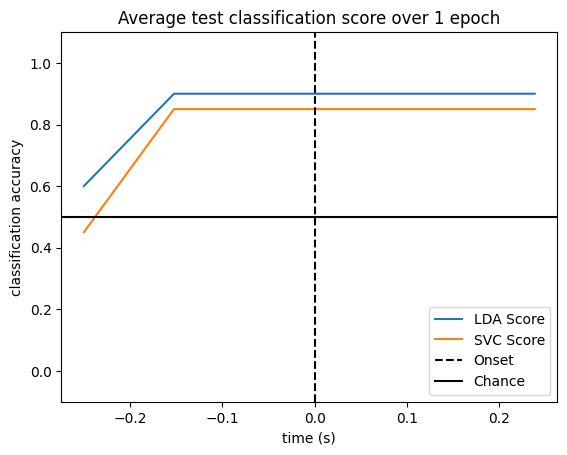

In [132]:
fig = plt.figure()
plt.plot(w_times, np.mean(scores_windows_lda, 0), label="LDA Score")
plt.plot(w_times, np.mean(scores_windows_svc, 0), label="SVC Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.ylim(-0.1,1.1)
plt.title("Average test classification score over 1 epoch")
plt.legend(loc="lower right")
plt.show()
# plt.savefig('images/classifier_score_window.eps', format='eps')
fig.savefig('{}/classifier_score_window_'.format(dir)+str(SUBJECT)+'_'+str(TRIAL)+'.pdf')